In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, BatchNormalization,Activation
from tensorflow.keras.layers import LeakyReLU,Concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint
# from models.unet import *
from models.skipnet import *
from models.resnet import *
from utils.common import *
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import rescale, pyramid_reduce
import os
import scipy.io as sio
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# Load data (data are preprocessed by Matlab)
coastal_data=False
if coastal_data:     #Costal data
    dname="coastal"
    datapath="data/coastal.mat"
    coastal=sio.loadmat(datapath)
    X=coastal["xim"]
    scale=np.max(X)
    x=X/scale #ground truth (10 m band)
    y=coastal["yD"]/scale #input (20 m band)
    xD=coastal["xU"] #interpolated 20 m bands to spatial size of 10 m band
else:                #Reykjavik
    dname="rek"
    datapath="data/reykjavik.mat"
    data = sio.loadmat(datapath)
    X=data["x20"] #ground truth
    scale=np.max(X)
    x=X/scale
    y=data["yD"]/scale #input
    
#     We can use another downsampling technique instead of bicubic
    # yD=pyramid_reduce(y)
    # xD=rescale(pyramid_reduce(x),scale=r,order=5)
print(scale)

6831


In [3]:
Y=GenerateCube(y,stride=8) #input
X=GenerateCube(x,stride=8) #target
Yt=y.reshape(-1,y.shape[0],y.shape[1],y.shape[2])
Xt=x.reshape(-1,x.shape[0],x.shape[1],x.shape[2])
print(Y.shape,Xt.shape)

(961, 16, 16, 10) (1, 256, 256, 6)


In [4]:
num_epochs = 200

skipnet=False

if skipnet:
    netname="skipnet"
    batch_size= 64
    mymodel=skip(ndown=3)
    myoptimizer=tf.keras.optimizers.Adam(learning_rate=0.0005)
    mymodel.compile(optimizer=myoptimizer, loss="mse")
else:
    netname="resnet"
    batch_size= 48
    mymodel=residualnet(K=16)
    myoptimizer=tf.keras.optimizers.Adam(learning_rate=0.0004)
    mymodel.compile(optimizer=myoptimizer, loss="mse")
# mymodel.summary()
modelpath=netname+"bestmodel.hdf5"
checkpoint = ModelCheckpoint(modelpath, monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

In [5]:
h=mymodel.fit(x=Y,y=X,batch_size=batch_size,epochs=num_epochs,validation_data=(Yt,Xt),callbacks=callbacks_list)

Train on 961 samples, validate on 1 samples
Epoch 1/200
912/961 [===========================>..] - ETA: 0s - loss: 0.1528
Epoch 00001: val_loss improved from inf to 0.00325, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 4s 4ms/sample - loss: 0.1453 - val_loss: 0.0032
Epoch 2/200
864/961 [=========================>....] - ETA: 0s - loss: 0.0021
Epoch 00002: val_loss improved from 0.00325 to 0.00146, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 788us/sample - loss: 0.0020 - val_loss: 0.0015
Epoch 3/200
864/961 [=========================>....] - ETA: 0s - loss: 0.0015
Epoch 00003: val_loss improved from 0.00146 to 0.00131, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 803us/sample - loss: 0.0015 - val_loss: 0.0013
Epoch 4/200
864/961 [=========================>....] - ETA: 0s - loss: 0.0014
Epoch 00004: val_loss improved from 0.00131 to 0.00127, saving model to resnetbestmodel.hdf5

912/961 [===========================>..] - ETA: 0s - loss: 5.5330e-04
Epoch 00031: val_loss improved from 0.00042 to 0.00040, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 764us/sample - loss: 5.4998e-04 - val_loss: 4.0236e-04
Epoch 32/200
912/961 [===========================>..] - ETA: 0s - loss: 5.3626e-04
Epoch 00032: val_loss improved from 0.00040 to 0.00039, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 753us/sample - loss: 5.3707e-04 - val_loss: 3.8834e-04
Epoch 33/200
912/961 [===========================>..] - ETA: 0s - loss: 5.2017e-04
Epoch 00033: val_loss improved from 0.00039 to 0.00038, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 767us/sample - loss: 5.2382e-04 - val_loss: 3.8440e-04
Epoch 34/200
912/961 [===========================>..] - ETA: 0s - loss: 5.1404e-04
Epoch 00034: val_loss improved from 0.00038 to 0.00038, saving model to resnetbestmodel.hdf5
961/96

961/961 [==============================] - 1s 778us/sample - loss: 3.5658e-04 - val_loss: 2.6445e-04
Epoch 61/200
864/961 [=========================>....] - ETA: 0s - loss: 3.5277e-04
Epoch 00061: val_loss improved from 0.00026 to 0.00026, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 752us/sample - loss: 3.5438e-04 - val_loss: 2.6321e-04
Epoch 62/200
912/961 [===========================>..] - ETA: 0s - loss: 3.5439e-04
Epoch 00062: val_loss improved from 0.00026 to 0.00026, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 767us/sample - loss: 3.5108e-04 - val_loss: 2.6157e-04
Epoch 63/200
912/961 [===========================>..] - ETA: 0s - loss: 3.5091e-04
Epoch 00063: val_loss improved from 0.00026 to 0.00026, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 745us/sample - loss: 3.4956e-04 - val_loss: 2.6018e-04
Epoch 64/200
912/961 [===========================>..] - ETA: 0s - lo

912/961 [===========================>..] - ETA: 0s - loss: 3.0054e-04
Epoch 00091: val_loss improved from 0.00023 to 0.00023, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 773us/sample - loss: 2.9996e-04 - val_loss: 2.3158e-04
Epoch 92/200
912/961 [===========================>..] - ETA: 0s - loss: 2.9556e-04
Epoch 00092: val_loss improved from 0.00023 to 0.00023, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 744us/sample - loss: 2.9681e-04 - val_loss: 2.3128e-04
Epoch 93/200
912/961 [===========================>..] - ETA: 0s - loss: 2.9610e-04
Epoch 00093: val_loss did not improve from 0.00023
961/961 [==============================] - 1s 584us/sample - loss: 2.9573e-04 - val_loss: 2.3306e-04
Epoch 94/200
960/961 [============================>.] - ETA: 0s - loss: 2.9531e-04
Epoch 00094: val_loss improved from 0.00023 to 0.00023, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 75

Epoch 123/200
912/961 [===========================>..] - ETA: 0s - loss: 2.7244e-04
Epoch 00123: val_loss did not improve from 0.00022
961/961 [==============================] - 1s 602us/sample - loss: 2.7038e-04 - val_loss: 2.1875e-04
Epoch 124/200
912/961 [===========================>..] - ETA: 0s - loss: 2.7028e-04
Epoch 00124: val_loss did not improve from 0.00022
961/961 [==============================] - 1s 561us/sample - loss: 2.7070e-04 - val_loss: 2.1798e-04
Epoch 125/200
864/961 [=========================>....] - ETA: 0s - loss: 2.6584e-04
Epoch 00125: val_loss improved from 0.00022 to 0.00022, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 825us/sample - loss: 2.6722e-04 - val_loss: 2.1623e-04
Epoch 126/200
960/961 [============================>.] - ETA: 0s - loss: 2.6677e-04
Epoch 00126: val_loss improved from 0.00022 to 0.00021, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 761us/sample - loss: 2.6671

Epoch 156/200
912/961 [===========================>..] - ETA: 0s - loss: 2.4939e-04
Epoch 00156: val_loss did not improve from 0.00021
961/961 [==============================] - 1s 561us/sample - loss: 2.4921e-04 - val_loss: 2.0762e-04
Epoch 157/200
864/961 [=========================>....] - ETA: 0s - loss: 2.5076e-04
Epoch 00157: val_loss did not improve from 0.00021
961/961 [==============================] - 1s 597us/sample - loss: 2.4891e-04 - val_loss: 2.0716e-04
Epoch 158/200
912/961 [===========================>..] - ETA: 0s - loss: 2.5070e-04
Epoch 00158: val_loss improved from 0.00021 to 0.00020, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 774us/sample - loss: 2.5040e-04 - val_loss: 2.0461e-04
Epoch 159/200
960/961 [============================>.] - ETA: 0s - loss: 2.4766e-04
Epoch 00159: val_loss improved from 0.00020 to 0.00020, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 783us/sample - loss: 2.4768

961/961 [==============================] - 1s 766us/sample - loss: 2.3667e-04 - val_loss: 1.9622e-04
Epoch 189/200
912/961 [===========================>..] - ETA: 0s - loss: 2.3471e-04
Epoch 00189: val_loss improved from 0.00020 to 0.00020, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 804us/sample - loss: 2.3399e-04 - val_loss: 1.9590e-04
Epoch 190/200
960/961 [============================>.] - ETA: 0s - loss: 2.3300e-04
Epoch 00190: val_loss improved from 0.00020 to 0.00020, saving model to resnetbestmodel.hdf5
961/961 [==============================] - 1s 778us/sample - loss: 2.3293e-04 - val_loss: 1.9530e-04
Epoch 191/200
960/961 [============================>.] - ETA: 0s - loss: 2.3225e-04
Epoch 00191: val_loss did not improve from 0.00020
961/961 [==============================] - 1s 597us/sample - loss: 2.3210e-04 - val_loss: 1.9552e-04
Epoch 192/200
912/961 [===========================>..] - ETA: 0s - loss: 2.3301e-04
Epoch 00192: val_loss i

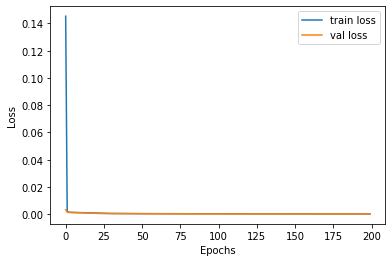

In [6]:
fig1=plt.figure()
plt.plot(range(num_epochs),h.history["loss"],label="train loss")
plt.plot(range(num_epochs),h.history["val_loss"],label="val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# fig1.savefig("skipnetloss_rek.png")

In [7]:
bestmodel=tf.keras.models.load_model(modelpath)
Ypr=bestmodel.predict(y.reshape(-1,y.shape[0],y.shape[1],y.shape[2]))
Ypr=Ypr*scale

Each band [24.0342051  27.27951604 27.57427314 28.39492495 26.4581451  22.21935589]
Mean SRE:  25.993403369688085


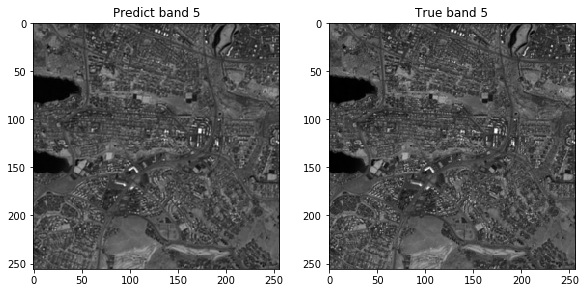

In [8]:
msre,sre=sreCal(x*scale,Ypr[0])
# bmsre,bsre=sreCal(x,xD)
print("Each band",sre)
print("Mean SRE: ",msre)
# print("Each band bicubic",bsre)
# print("Mean SRE bicubic: ",bmsre)
plt.figure(figsize=(15,15))
band=0
plt.subplot(131)
plt.imshow(Ypr[0][:,:,1],cmap="gray")
plt.title("Predict band 5")
plt.subplot(132)
plt.imshow(x[:,:,1],cmap="gray")
plt.title("True band 5")
# plt.subplot(133)
# plt.imshow(xD[:,:,showband],cmap="gray")
# plt.title("Bicubic band 5")
plt.show()